In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define ZIP file path (Use your actual path)
zip_path = "/content/ashrae-energy-prediction.zip"

# Define extraction folder
extract_path = "/content/Downloads"
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP file
!unzip -q "$zip_path" -d "$extract_path"

# List extracted files
!ls "$extract_path"



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace /content/Downloads/building_metadata.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: building_metadata.csv  test.csv   weather_test.csv
sample_submission.csv  train.csv  weather_train.csv


In [ ]:
import glob
excel_files = glob.glob(f"{extract_path}/*.xlsx")
print("Found Excel files:", excel_files)

Found Excel files: []


LOAD DATASET

In [ ]:
def load_all_data(excel_files):
    dataframes = {}
    for file in excel_files:
        sheet_names = pd.ExcelFile(file, engine='openpyxl').sheet_names
        for sheet in sheet_names:
            df = pd.read_excel(file, sheet_name=sheet, engine='openpyxl')
            df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
            df.set_index('Time', inplace=True)
            df.dropna(inplace=True)
            dataframes[f"{os.path.basename(file)}_{sheet}"] = df
    return dataframes

In [ ]:
datasets = load_all_data(excel_files)

In [ ]:
import pandas as pd
import os
import glob

# Path to extracted files
extracted_path = "/content/Downloads"

# Get all CSV files
csv_files = glob.glob(os.path.join(extracted_path, "*.csv"))

# Load all CSV files into a dictionary
datasets = {}
for file in csv_files:
    key = os.path.basename(file)  # Use filename as dictionary key
    datasets[key] = pd.read_csv(file)

# Print available dataset keys
print("Loaded datasets:", datasets.keys())


Loaded datasets: dict_keys(['weather_test.csv', 'sample_submission.csv', 'test.csv', 'weather_train.csv', 'building_metadata.csv', 'train.csv'])


In [ ]:
print("Loaded datasets:", datasets.keys())

Loaded datasets: dict_keys(['weather_test.csv', 'sample_submission.csv', 'test.csv', 'weather_train.csv', 'building_metadata.csv', 'train.csv'])


In [ ]:
energy_df = datasets.get("train.csv")  # Main energy dataset
weather_df = datasets.get("weather_train.csv")  # Weather dataset

PREPROCESS DATA

In [ ]:
def preprocess_data(df):
    # Convert 'timestamp' column to datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set it as index
    df.set_index('timestamp', inplace=True)

    # Now resampling will work
    df = df.resample('h').mean().fillna(method='ffill').fillna(method='bfill')

    # Feature engineering
    df['Hour'] = df.index.hour
    df['Day'] = df.index.day
    df['Month'] = df.index.month
    df['DayOfWeek'] = df.index.dayofweek
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)

    return df


In [ ]:
energy_df = preprocess_data(energy_df)
weather_df = preprocess_data(weather_df)


<ipython-input-44-1712cf91bdb3>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('h').mean().fillna(method='ffill').fillna(method='bfill')
<ipython-input-44-1712cf91bdb3>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.resample('h').mean().fillna(method='ffill').fillna(method='bfill')


In [ ]:
print("Columns in energy_df:", energy_df.columns.tolist())

Columns in energy_df: ['building_id', 'meter', 'meter_reading', 'Hour_x', 'Day_x', 'Month_x', 'DayOfWeek_x', 'IsWeekend_x', 'site_id_x', 'air_temperature_x', 'cloud_coverage_x', 'dew_temperature_x', 'precip_depth_1_hr_x', 'sea_level_pressure_x', 'wind_direction_x', 'wind_speed_x', 'Hour_y', 'Day_y', 'Month_y', 'DayOfWeek_y', 'IsWeekend_y', 'site_id_y', 'air_temperature_y', 'cloud_coverage_y', 'dew_temperature_y', 'precip_depth_1_hr_y', 'sea_level_pressure_y', 'wind_direction_y', 'wind_speed_y', 'Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend']


In [ ]:
def create_features(df, weather_df=None):
    features = ['Hour', 'Day', 'Month', 'DayOfWeek', 'IsWeekend']
    if weather_df is not None:
        df = df.merge(weather_df, left_index=True, right_index=True, how='left')
        features.extend(['Temperature', 'Humidity', 'WindSpeed'])
    return df, features

In [ ]:
X = energy_df[features]


In [ ]:
print(energy_df.head())  # Check if 'meter_reading' column exists
print(energy_df.info())  # Ensure 'meter_reading' is numeric and not null


                     building_id     meter  meter_reading  Hour_x  Day_x  \
timestamp                                                                  
2016-01-01 00:00:00   814.279444  0.658409    1830.197129       0      1   
2016-01-01 01:00:00   814.066289  0.655037    1854.113477       1      1   
2016-01-01 02:00:00   814.210526  0.658112     547.888374       2      1   
2016-01-01 03:00:00   813.969077  0.654617     439.471739       3      1   
2016-01-01 04:00:00   814.433362  0.654617     509.867363       4      1   

                     Month_x  DayOfWeek_x  IsWeekend_x  site_id_x  \
timestamp                                                           
2016-01-01 00:00:00        1            4            0   6.333333   
2016-01-01 01:00:00        1            4            0   7.500000   
2016-01-01 02:00:00        1            4            0   7.500000   
2016-01-01 03:00:00        1            4            0   7.500000   
2016-01-01 04:00:00        1            4            

VISUALIZATION

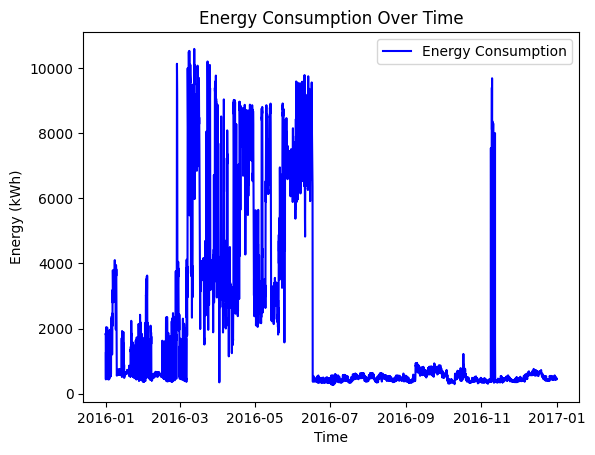

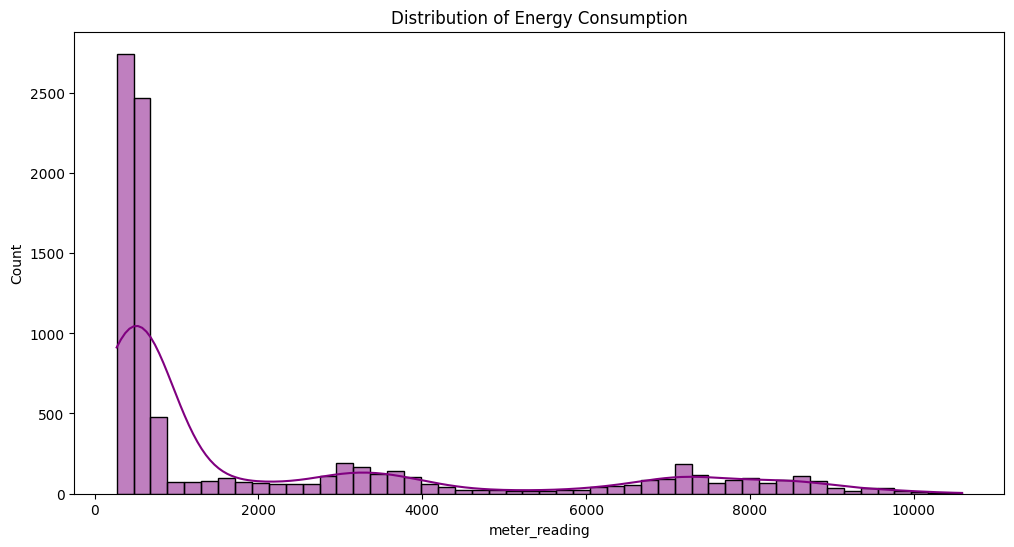

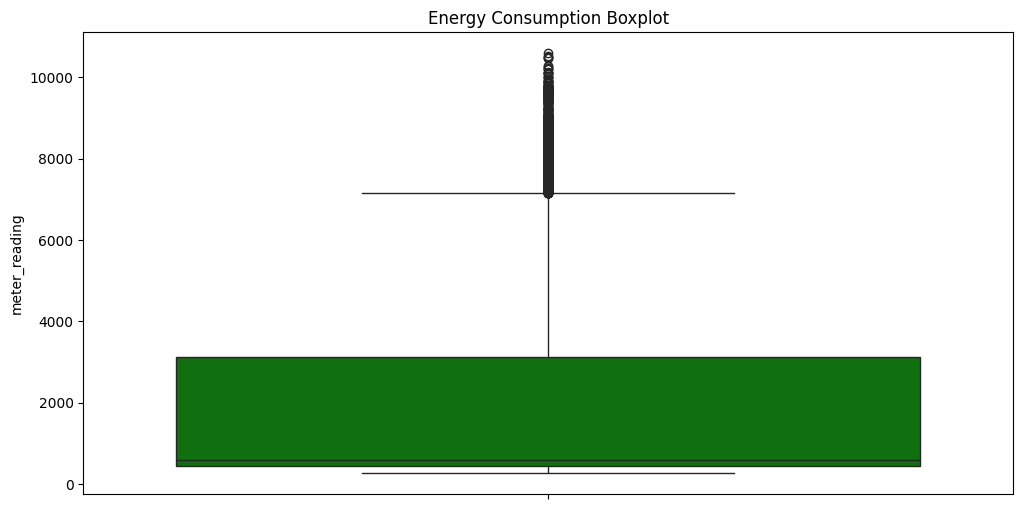

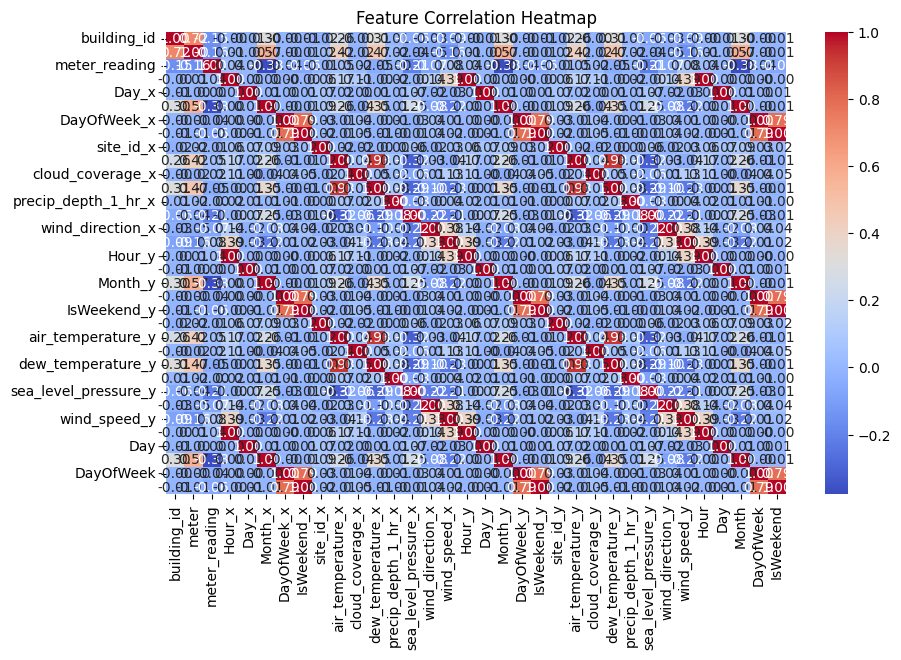

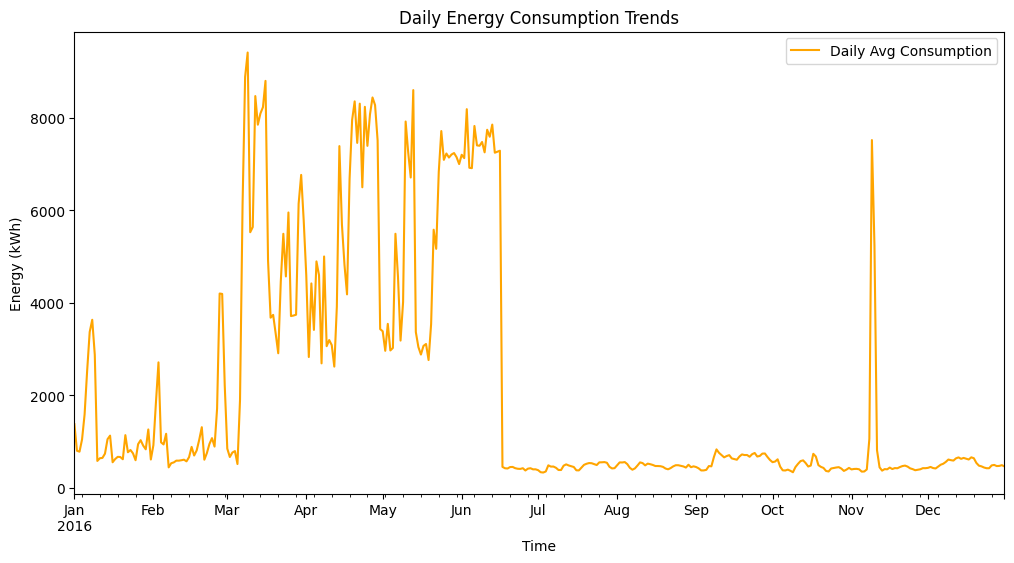

<ipython-input-91-de08603cc2c3>:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  energy_df['meter_reading'].resample('M').mean().plot(label='Monthly Avg Consumption', color='red')


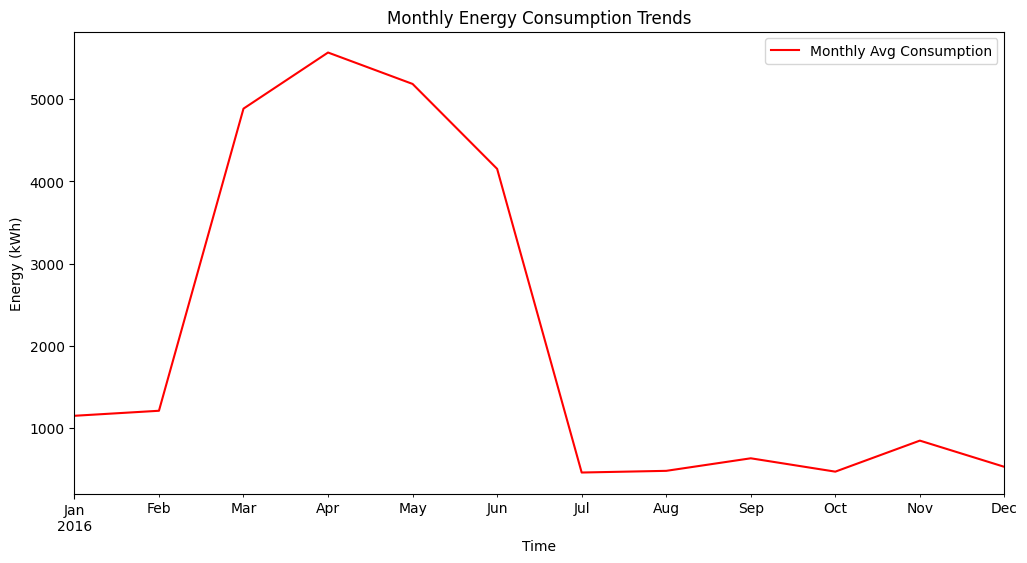

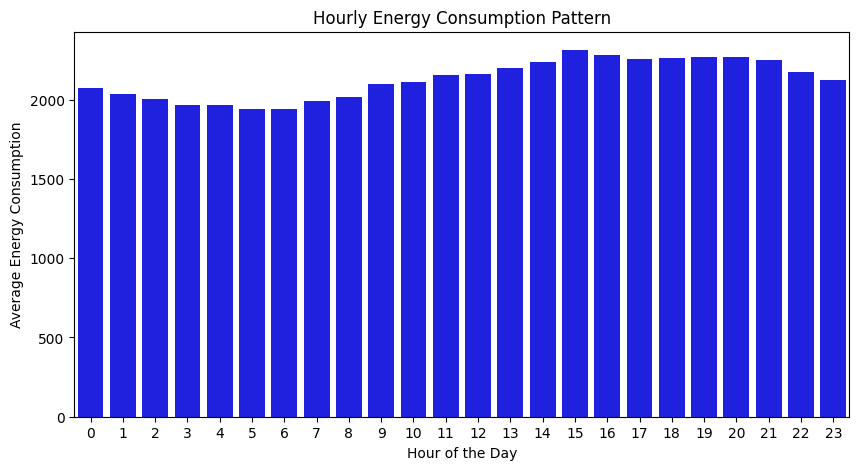

In [ ]:
def plot_energy_consumption(energy_df):
    plt.figure(figsize=(12, 6))
plt.plot(energy_df.index, energy_df['meter_reading'], label='Energy Consumption', color='blue')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.title('Energy Consumption Over Time')
plt.legend()
plt.show()

energy_df = energy_df[energy_df['meter_reading'].notna()]  # Remove NaN
energy_df = energy_df[np.isfinite(energy_df['meter_reading'])]  # Remove infinities

plt.figure(figsize=(12, 6))
sns.histplot(energy_df['meter_reading'], bins=50, kde=True, color='purple')
plt.title('Distribution of Energy Consumption')
plt.show()

# Boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(y=energy_df['meter_reading'], color='green')
plt.title('Energy Consumption Boxplot')
plt.show()


# Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(energy_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

# Line Plot- Daily Trends
plt.figure(figsize=(12, 6))
energy_df['meter_reading'].resample('D').mean().plot(label='Daily Avg Consumption', color='orange')
plt.title('Daily Energy Consumption Trends')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Monthly Trends
plt.figure(figsize=(12, 6))
energy_df['meter_reading'].resample('M').mean().plot(label='Monthly Avg Consumption', color='red')
plt.title('Monthly Energy Consumption Trends')
plt.xlabel('Time')
plt.ylabel('Energy (kWh)')
plt.legend()
plt.show()

# Bar Plot - Hourly Consumption
plt.figure(figsize=(10, 5))
sns.barplot(x=energy_df.groupby('Hour')['meter_reading'].mean().index,
            y=energy_df.groupby('Hour')['meter_reading'].mean().values, color='blue')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption')
plt.title('Hourly Energy Consumption Pattern')
plt.show()




In [ ]:
import os
extracted_path = "/content/Downloads"  # Change if extracted elsewhere
print("Extracted files:", os.listdir(extracted_path))


Extracted files: ['weather_test.csv', 'sample_submission.csv', 'test.csv', 'weather_train.csv', 'building_metadata.csv', 'train.csv']


In [ ]:
# Ensure both datasets have a common column for merging
merged_df = weather_df.merge(energy_df[['meter_reading']], left_index=True, right_index=True, how='inner')
print(merged_df.head())  # Check if the data is merged correctly


                      site_id  air_temperature  cloud_coverage  \
timestamp                                                        
2016-01-01 00:00:00  6.333333         7.711111        6.333333   
2016-01-01 01:00:00  7.500000         5.881250        0.571429   
2016-01-01 02:00:00  7.500000         5.168750        1.555556   
2016-01-01 03:00:00  7.500000         4.900000        1.777778   
2016-01-01 04:00:00  7.000000         4.720000        1.500000   

                     dew_temperature  precip_depth_1_hr  sea_level_pressure  \
timestamp                                                                     
2016-01-01 00:00:00         2.133333               -0.3         1018.688889   
2016-01-01 01:00:00         1.256250               -0.3         1021.128571   
2016-01-01 02:00:00         1.006250               -0.1         1021.300000   
2016-01-01 03:00:00         0.512500               -0.1         1021.292857   
2016-01-01 04:00:00         0.620000               -0.2        

WEATHER DATA VISUALIZATION

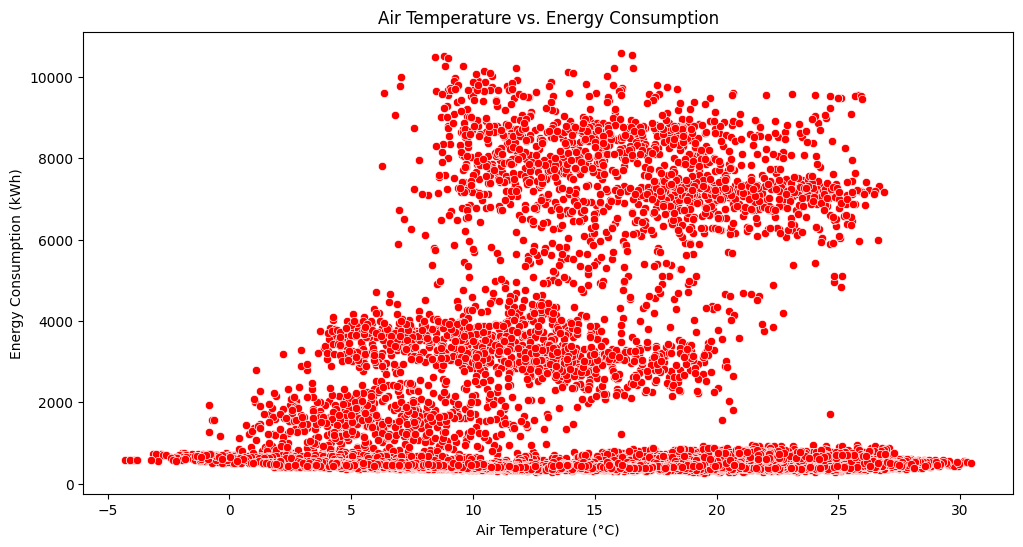

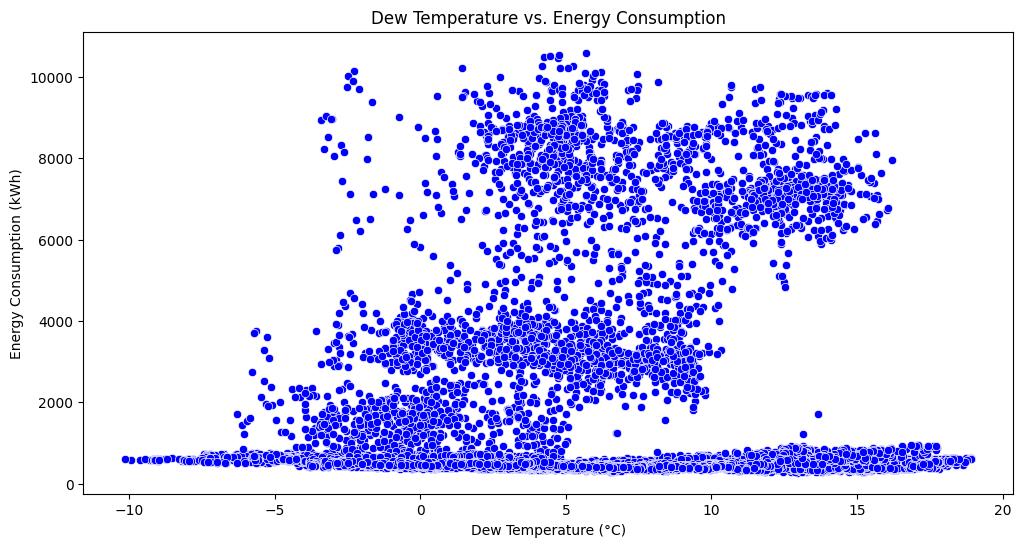

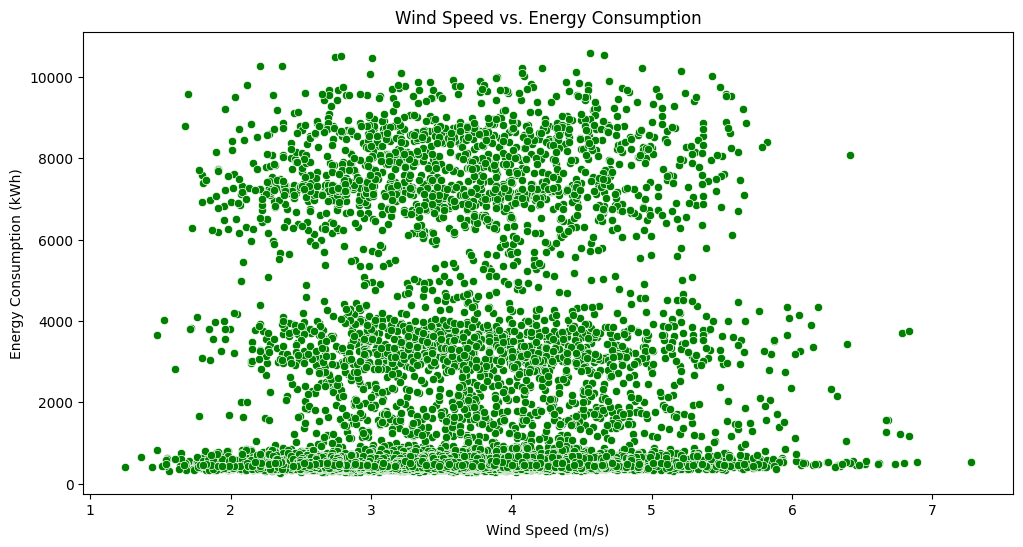

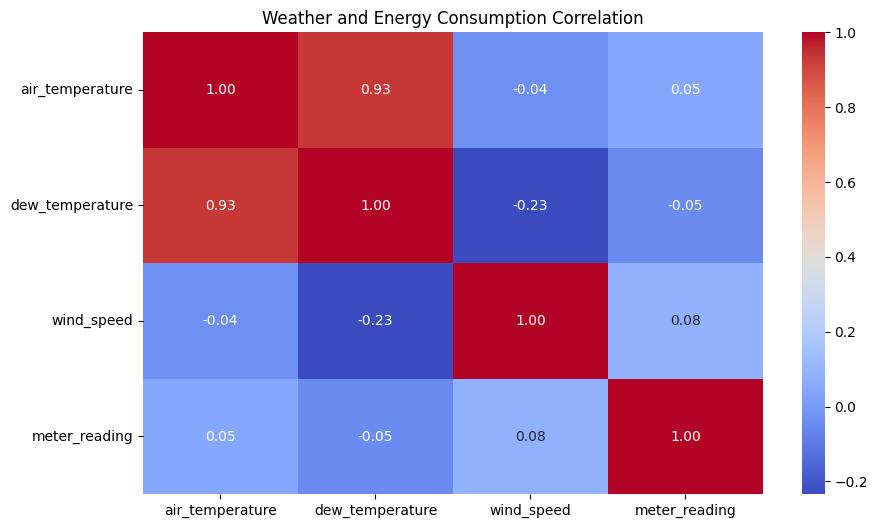

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Temperature vs Energy Consumption
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_df['air_temperature'], y=merged_df['meter_reading'], color='red')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Air Temperature vs. Energy Consumption')
plt.show()

# Dew Temperature vs Energy Consumption
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_df['dew_temperature'], y=merged_df['meter_reading'], color='blue')
plt.xlabel('Dew Temperature (°C)')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Dew Temperature vs. Energy Consumption')
plt.show()

# Wind Speed vs Energy Consumption
plt.figure(figsize=(12, 6))
sns.scatterplot(x=merged_df['wind_speed'], y=merged_df['meter_reading'], color='green')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Wind Speed vs. Energy Consumption')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(merged_df[['air_temperature', 'dew_temperature', 'wind_speed', 'meter_reading']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Weather and Energy Consumption Correlation')
plt.show()


Train SVM Model

In [ ]:
def train_svm(X_train, y_train):
    svm = SVR(kernel='rbf')
    param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

Train Random Forest Model

In [ ]:
def train_random_forest(X_train, y_train):
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    return rf

Train XGB Regressor

In [ ]:
from xgboost import XGBRegressor
def train_xgboost(X_train, y_train):
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
    xgb.fit(X_train, y_train)
    return xgb

Test-Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train Models

In [ ]:
svm_model = train_svm(X_train, y_train)
rf_model = train_random_forest(X_train, y_train)
xgb_model = train_xgboost(X_train, y_train)

Predictions

In [ ]:
svm_pred = svm_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

Evaluation

In [ ]:
metrics = {
    'Model': ['SVM', 'Random Forest', 'XGBoost'],
    'MAE': [mean_absolute_error(y_test, svm_pred), mean_absolute_error(y_test, rf_pred), mean_absolute_error(y_test, xgb_pred)],
    'MSE': [mean_squared_error(y_test, svm_pred), mean_squared_error(y_test, rf_pred), mean_squared_error(y_test, xgb_pred)],
    'R2 Score': [r2_score(y_test, svm_pred), r2_score(y_test, rf_pred), r2_score(y_test, xgb_pred)]
}
metrics_df = pd.DataFrame(metrics)
print(metrics_df)


           Model          MAE           MSE  R2 Score
0            SVM  1348.487855  6.434478e+06  0.055278
1  Random Forest   241.678446  2.903450e+05  0.957371
2        XGBoost   328.203709  4.236888e+05  0.937793


Plot Predictions

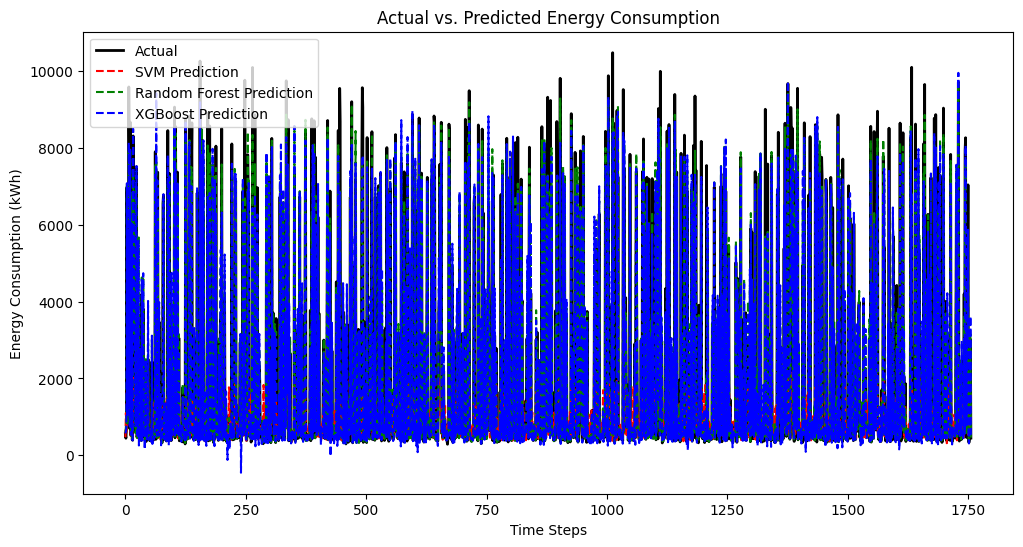

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", color="black", linewidth=2)
plt.plot(svm_pred, label="SVM Prediction", linestyle="dashed", color="red")
plt.plot(rf_pred, label="Random Forest Prediction", linestyle="dashed", color="green")
plt.plot(xgb_pred, label="XGBoost Prediction", linestyle="dashed", color="blue")
plt.legend()
plt.title("Actual vs. Predicted Energy Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Energy Consumption (kWh)")
plt.show()


Feature Importance for Random Forest

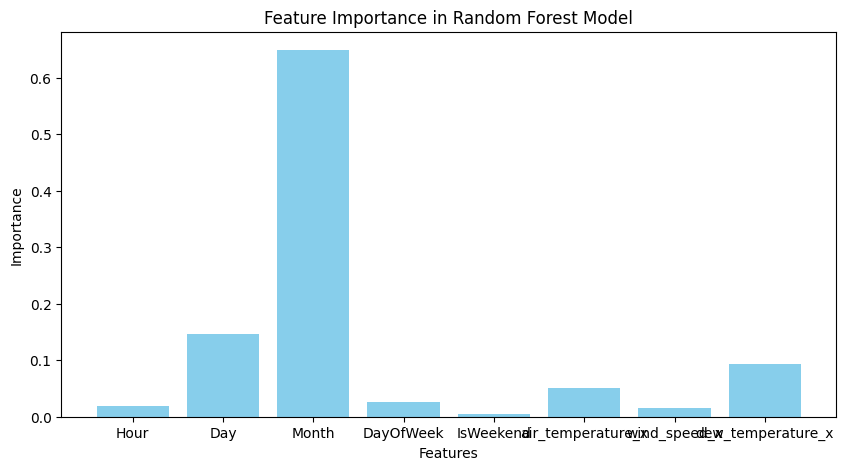

In [ ]:
plt.figure(figsize=(10, 5))
importance = rf_model.feature_importances_
plt.bar(X.columns, importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.show()